## Impact of Classifier Choice on the Performance Using `crop_data`
We are implementing our methods on real data. The `crop_data` dataset consists of over 200,000 instances with 175 features. I have randomly selected two out of seven crop types as inliers, with the remaining types considered as outliers. The One-Class Classifier used is `IsolationForest`, and the binary classifier is `LightGBM Classifier`.

I have found that the effectiveness of our procedure is highly dependent on the choice of OCC and binary classifier. The performance of our method significantly deteriorates if an unsuitable binary classifier is chosen. For instance, when using SVM, XGBoost, or Decision Tree Classifier as the binary classifier, our procedure tends to result in no rejections.  

In real data cases, the power of the method, which first estimates the proportions in unlabeled data and then uses a multi-step approach, is higher than that of the simple MAMCOD method, which only uses K one-class classifiers.

### Setup

In [109]:
# This helps when you're loading functions  defined in an external script (if the script is updated while the notebook is running)
%load_ext autoreload 
%autoreload 2
    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from statsmodels.stats.multitest import multipletests
import copy
import pomegranate
import torch
from pomegranate.distributions import *

np.set_printoptions(suppress=True)
%load_ext watermark
%watermark -m -n -p numpy,torch,pomegranate

import sys
sys.path.append("..")

from mypackage.data_models import sample_from_real_data
from mypackage.PUL import compute_pu_scores,prepare_pu_score_matrices
from mypackage.MAMCOD_procedure import compute_MAMCOD_conformal_pv, compute_fdr_power, compute_standard_conformal_scores
from mypackage.Proportion_Estimation import adjust_proportions, compute_mean_distance, adjust_proportions_mixture_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
numpy      : 1.26.4
torch      : 2.4.0
pomegranate: 1.1.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : AMD64 Family 25 Model 80 Stepping 0, AuthenticAMD
CPU cores   : 16
Architecture: 64bit



## Data Generation

In [110]:
# Read the data from the file
crop_data = pd.read_csv("../Data_Crop/WinnipegDataset.txt")

# Display the counts of unique values in the first column
crop_data.iloc[:, 0].value_counts()

label
6    85074
3    75673
4    74067
5    47117
1    39162
2     3598
7     1143
Name: count, dtype: int64

In [111]:
np.random.seed(0)

# Parameters
crop_data = crop_data.to_numpy()
K = 2
in_class_labels = [4,5]

# Size of Training, Calibration, and Test data
n_in_train = [1000,1000]
n_in_cal = [1000, 1000]
num_in_test = 900
n_in_test = [450, 450]
n_out_test = 100
n_test = sum(n_in_test) + n_out_test

# Calculate the proportions of each type of inliers in the calibration and test data
n_in_cal_test = n_in_cal + n_in_test
n_in_total = sum(n_in_cal_test)
proportions = [count / n_in_total for count in n_in_cal_test]

# Range of rho values
rho_values = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

# Monte Carlo iterations
num_iterations = 10

## Preparation

In [112]:
# Define machine learning models
from sklearn.svm import SVC, OneClassSVM
from sklearn.ensemble import RandomForestClassifier, IsolationForest
import lightgbm as lgb

# Define machine learning models
binary_classifier = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, num_leaves=31, random_state=42)
oneclass_classifier = IsolationForest(contamination='auto')

In [113]:
# Store results
mean_fdr = {
    'MAMCOD': [],
    'standard_bootstrap': [],
    'normal': [],
    'gamma': []
}

ci_fdr = {
    'MAMCOD': [],
    'standard_bootstrap': [],
    'normal': [],
    'gamma': []   
}

mean_power = {
    'MAMCOD': [],
    'standard_bootstrap': [],
    'normal': [],
    'gamma': []
}

ci_power = {
    'MAMCOD': [],
    'standard_bootstrap': [],
    'normal': [],
    'gamma': []
}

### PU Learning

In [114]:
for rho in rho_values:
    n_in_test = [int(rho * num_in_test), num_in_test- int(rho * num_in_test) ]

    fdr_vec = []
    fdr_standard_bootstrap_vec = []
    fdr_normal_vec = []
    fdr_gamma_vec = []
    power_vec = []
    power_standard_bootstrap_vec = []
    power_normal_vec = []
    power_gamma_vec = []

    for _ in range(num_iterations):
        # Generate initial training, calibration, and test data
        X_train, Y_train,_ = sample_from_real_data(crop_data, in_class_labels, n_in_train, 0)
        X_cal, Y_cal,_ = sample_from_real_data(_, in_class_labels, n_in_cal, 0)
        X_test, Y_test,_ = sample_from_real_data(_, in_class_labels, n_in_test, n_out_test)

        # Adjust the proportions in the training data
        X_train_bootstrap, Y_train_bootstrap, occ_list_bootstrap = adjust_proportions(X_train, Y_train, X_cal, X_test, oneclass_classifier, K, method='bootstrap')
        X_train_normal, Y_train_normal, occ_list_normal  = adjust_proportions_mixture_model(K, X_train, Y_train, X_cal, X_test, oneclass_classifier, sample_method='bootstrap', mixture_distributions = 'normal')
        X_train_gamma, Y_train_gamma, occ_list_gamma = adjust_proportions_mixture_model(K, X_train, Y_train, X_cal, X_test, oneclass_classifier, sample_method='bootstrap', mixture_distributions = 'gamma')

        # Compute PU scores
        scores_cal_MamCod, scores_test_MamCod = compute_standard_conformal_scores(
            K, X_train, Y_train, X_cal, Y_cal, X_test, oneclass_classifier)
        
        scores_cal_standard_bootstrap, scores_test_standard_bootstrap, _ = compute_pu_scores(
            K, X_train_bootstrap, Y_train_bootstrap, X_cal, Y_cal, X_test, binary_classifier,
            occ_list_bootstrap, multi_step=True)

        scores_cal_normal, scores_test_normal, _ = compute_pu_scores(
            K, X_train_normal, Y_train_normal, X_cal, Y_cal, X_test, binary_classifier,
            occ_list_normal, multi_step=True)

        scores_cal_gamma, scores_test_gamma, _ = compute_pu_scores(
            K, X_train_gamma, Y_train_gamma, X_cal, Y_cal, X_test, binary_classifier,
            occ_list_gamma, multi_step=True)

        # transform the format of scores
        scores_cal_mat_standard_bootstrap, scores_test_mat_standard_bootstrap = prepare_pu_score_matrices(
            K, n_in_cal, n_test, scores_cal_standard_bootstrap, scores_test_standard_bootstrap)
        
        scores_cal_mat_normal, scores_test_mat_normal = prepare_pu_score_matrices(
            K, n_in_cal, n_test, scores_cal_normal, scores_test_normal)
        
        scores_cal_mat_gamma, scores_test_mat_gamma = prepare_pu_score_matrices(
            K, n_in_cal, n_test, scores_cal_gamma, scores_test_gamma)

        # Compute MAMCOD conformal p-values
        MAMCOD_pv = compute_MAMCOD_conformal_pv(K, n_in_cal, scores_cal_MamCod, scores_test_MamCod, is_high_score_inlier = True)
        MAMCOD_pv_standard_bootstrap = compute_MAMCOD_conformal_pv(K, n_in_cal, scores_cal_mat_standard_bootstrap, scores_test_mat_standard_bootstrap, is_high_score_inlier = False)
        MAMCOD_pv_normal = compute_MAMCOD_conformal_pv(K, n_in_cal, scores_cal_mat_normal, scores_test_mat_normal, is_high_score_inlier = False)
        MAMCOD_pv_gamma = compute_MAMCOD_conformal_pv(K, n_in_cal, scores_cal_mat_gamma, scores_test_mat_gamma, is_high_score_inlier = False)

        # Compute FDR and Power by BH procedure
        fdr, power = compute_fdr_power(MAMCOD_pv, Y_test, alpha = 0.1)
        fdr_standard_bootstrap, power_standard_bootstrap = compute_fdr_power(MAMCOD_pv_standard_bootstrap, Y_test, alpha = 0.1)
        fdr_normal, power_normal = compute_fdr_power(MAMCOD_pv_normal, Y_test, alpha = 0.1)
        fdr_gamma, power_gamma = compute_fdr_power(MAMCOD_pv_gamma, Y_test, alpha = 0.1)
        
        fdr_vec.append(fdr)
        fdr_standard_bootstrap_vec.append(fdr_standard_bootstrap)
        fdr_normal_vec.append(fdr_normal)
        fdr_gamma_vec.append(fdr_gamma)
        power_vec.append(power)
        power_standard_bootstrap_vec.append(power_standard_bootstrap)
        power_normal_vec.append(power_normal)
        power_gamma_vec.append(power_gamma)    

    # Calculate mean FDR and Power
    mean_fdr['MAMCOD'].append(np.mean(fdr_vec))
    mean_fdr['standard_bootstrap'].append(np.mean(fdr_standard_bootstrap_vec))
    mean_fdr['normal'].append(np.mean(fdr_normal_vec))
    mean_fdr['gamma'].append(np.mean(fdr_gamma_vec))

    mean_power['MAMCOD'].append(np.mean(power_vec))
    mean_power['standard_bootstrap'].append(np.mean(power_standard_bootstrap_vec))
    mean_power['normal'].append(np.mean(power_normal_vec))
    mean_power['gamma'].append(np.mean(power_gamma_vec))

    # Compute the standard deviation    
    ci_fdr['MAMCOD'].append((np.percentile(fdr_vec, 5), np.percentile(fdr_vec, 95)))
    ci_fdr['standard_bootstrap'].append((np.percentile(fdr_standard_bootstrap_vec, 5), np.percentile(fdr_standard_bootstrap_vec, 95)))
    ci_fdr['normal'].append((np.percentile(fdr_normal_vec, 5), np.percentile(fdr_normal_vec, 95)))
    ci_fdr['gamma'].append((np.percentile(fdr_gamma_vec, 5), np.percentile(fdr_gamma_vec, 95)))
    
    ci_power['MAMCOD'].append((np.percentile(power_vec, 5), np.percentile(power_vec, 95)))
    ci_power['standard_bootstrap'].append((np.percentile(power_standard_bootstrap_vec, 5), np.percentile(power_standard_bootstrap_vec, 95)))
    ci_power['normal'].append((np.percentile(power_normal_vec, 5), np.percentile(power_normal_vec, 95)))
    ci_power['gamma'].append((np.percentile(power_gamma_vec, 5), np.percentile(power_gamma_vec, 95)))

[1] Improvement: 2181.908203125, Time: 0.002s
[2] Improvement: 19.9853515625, Time: 0.0009999s
[3] Improvement: 6.3896484375, Time: 0.002001s
[4] Improvement: 2.583984375, Time: 0.0009997s
[5] Improvement: 1.2255859375, Time: 0.001002s
[6] Improvement: 0.822265625, Time: 0.001001s
[7] Improvement: 0.75390625, Time: 0.001007s
[8] Improvement: 0.7978515625, Time: 0.0009987s
[9] Improvement: 0.935546875, Time: 0.0009999s
[10] Improvement: 1.130859375, Time: 0.001s
[11] Improvement: 1.3779296875, Time: 0.002511s
[12] Improvement: 1.673828125, Time: 0.001998s
[13] Improvement: 1.990234375, Time: 0.002s
[14] Improvement: 2.2607421875, Time: 0.002001s
[15] Improvement: 2.435546875, Time: 0.002s
[16] Improvement: 2.48046875, Time: 0.002s
[17] Improvement: 2.392578125, Time: 0.002s
[18] Improvement: 2.1943359375, Time: 0.002s
[19] Improvement: 1.9189453125, Time: 0.002s
[20] Improvement: 1.59375, Time: 0.002s
[21] Improvement: 1.2626953125, Time: 0.002002s
[22] Improvement: 0.955078125, Time: 0

### Plot

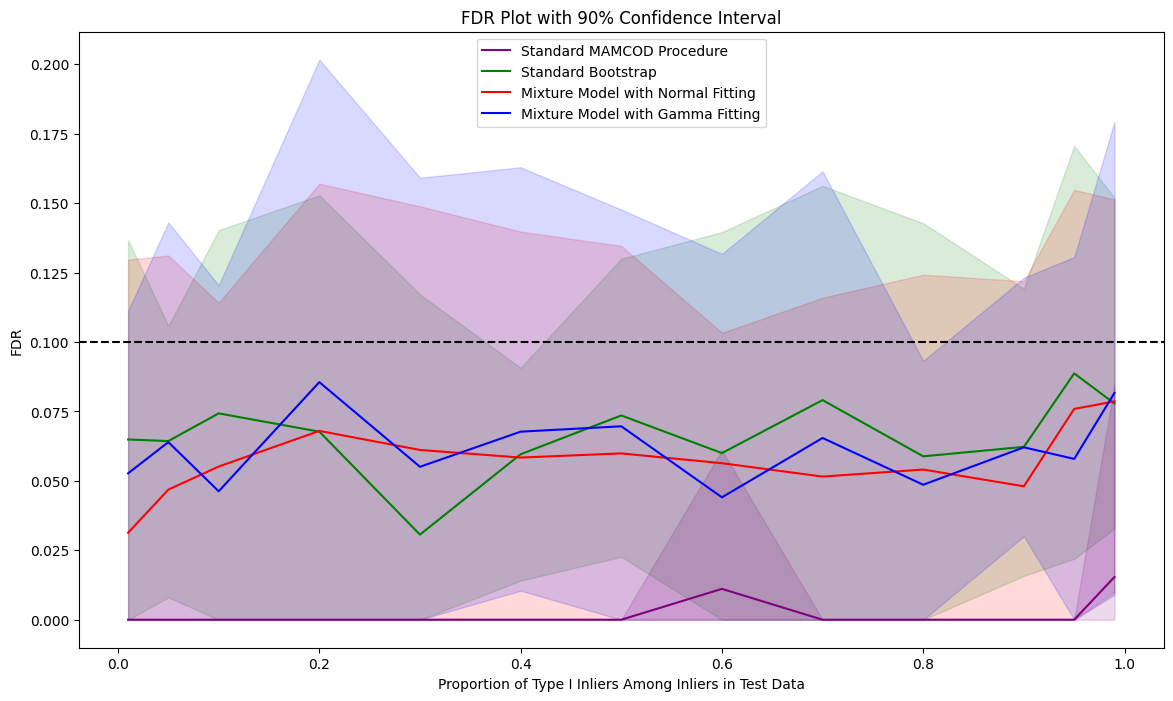

In [125]:
plt.figure(figsize=(14, 8))

plt.plot(rho_values, mean_fdr['MAMCOD'], label='Standard MAMCOD Procedure', color='purple', linestyle='-')
plt.fill_between(rho_values, [ci[0] for ci in ci_fdr['MAMCOD']], [ci[1] for ci in ci_fdr['MAMCOD']], color='purple', alpha=0.15)

plt.plot(rho_values, mean_fdr['standard_bootstrap'], label='Standard Bootstrap', color='green', linestyle='-')
plt.fill_between(rho_values, [ci[0] for ci in ci_fdr['standard_bootstrap']], [ci[1] for ci in ci_fdr['standard_bootstrap']], color='green', alpha=0.15)

plt.plot(rho_values, mean_fdr['normal'], label='Mixture Model with Normal Fitting', color='red', linestyle='-')
plt.fill_between(rho_values, [ci[0] for ci in ci_fdr['normal']], [ci[1] for ci in ci_fdr['normal']], color='red', alpha=0.15)

plt.plot(rho_values, mean_fdr['gamma'], label='Mixture Model with Gamma Fitting', color='blue', linestyle='-')
plt.fill_between(rho_values, [ci[0] for ci in ci_fdr['gamma']], [ci[1] for ci in ci_fdr['gamma']], color='blue', alpha=0.15)

plt.axhline(y=0.1, color='k', linestyle='--')

plt.xlabel('Proportion of Type I Inliers Among Inliers in Test Data')
plt.ylabel('FDR')
plt.title('FDR Plot with 90% Confidence Interval')
plt.legend()
plt.show()

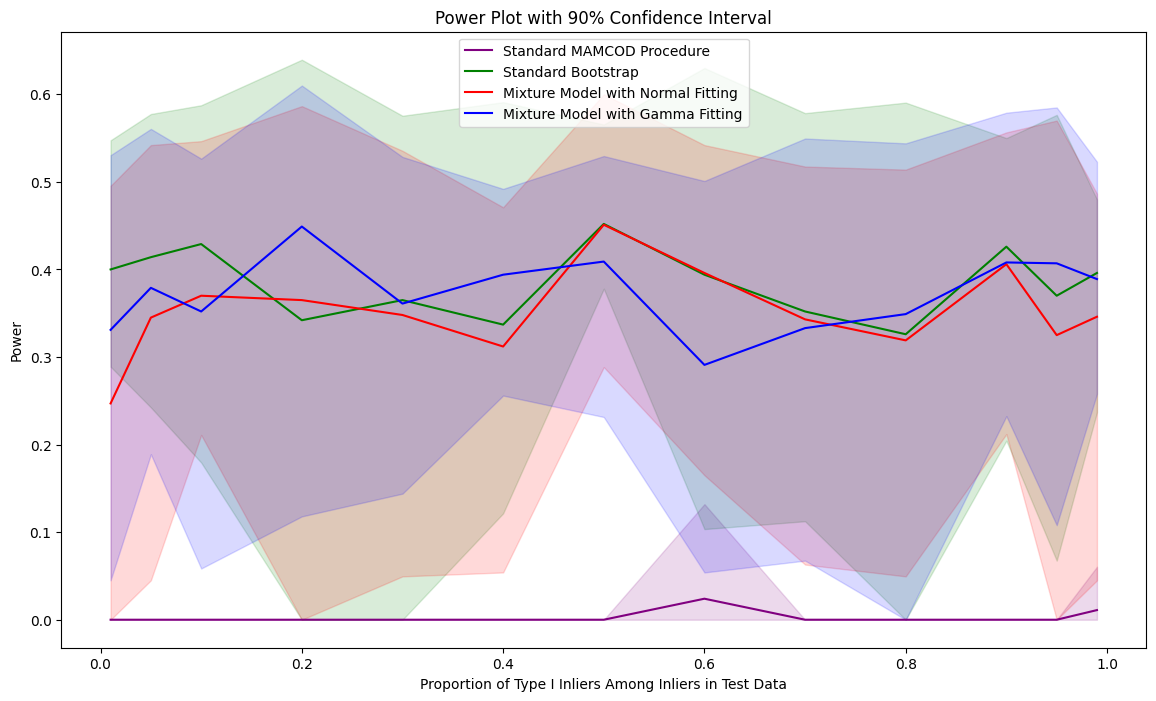

In [124]:
plt.figure(figsize=(14, 8))

plt.plot(rho_values, mean_power['MAMCOD'], label='Standard MAMCOD Procedure', color='purple', linestyle='-')
plt.fill_between(rho_values, [ci[0] for ci in ci_power['MAMCOD']], [ci[1] for ci in ci_power['MAMCOD']], color='purple', alpha=0.15)

plt.plot(rho_values, mean_power['standard_bootstrap'], label='Standard Bootstrap', color='green', linestyle='-')
plt.fill_between(rho_values, [ci[0] for ci in ci_power['standard_bootstrap']], [ci[1] for ci in ci_power['standard_bootstrap']], color='green', alpha=0.15)

plt.plot(rho_values, mean_power['normal'], label='Mixture Model with Normal Fitting', color='red', linestyle='-')
plt.fill_between(rho_values, [ci[0] for ci in ci_power['normal']], [ci[1] for ci in ci_power['normal']], color='red', alpha=0.15)

plt.plot(rho_values, mean_power['gamma'], label='Mixture Model with Gamma Fitting', color='blue', linestyle='-')
plt.fill_between(rho_values, [ci[0] for ci in ci_power['gamma']], [ci[1] for ci in ci_power['gamma']], color='blue', alpha=0.15)

plt.xlabel('Proportion of Type I Inliers Among Inliers in Test Data')
plt.ylabel('Power')
plt.title('Power Plot with 90% Confidence Interval')
plt.legend()
plt.show()